In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import numpy as np
import scipy as sp
from src import utils
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from src.net import CuiNet, DeepSpectraCNN, ResNet18_1D, ViT_1D
from src.training.training import Trainer
from src.utils.misc import TrainerConfig
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split



2025-05-09 12:35:15.005395: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#set project root
# Récupérer le répertoire du notebook actuel
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
# Remonter de deux niveaux dans l'arborescence pour atteindre la racine du projet
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
# Changer le répertoire de travail
os.chdir(project_root)
print(os.getcwd())

/home/metz/deepchemometrics/Aioly


In [3]:
data = sp.io.loadmat("data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


In [4]:
Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]
print("X and Y training set")
print(Ycal.shape)
print(Xcal.shape)
print("X and Y testing set")
print(Ytest.shape)
print(Xtest.shape)

X and Y training set
(9914, 1)
(9914, 618)
X and Y testing set
(1448, 1)
(1448, 618)


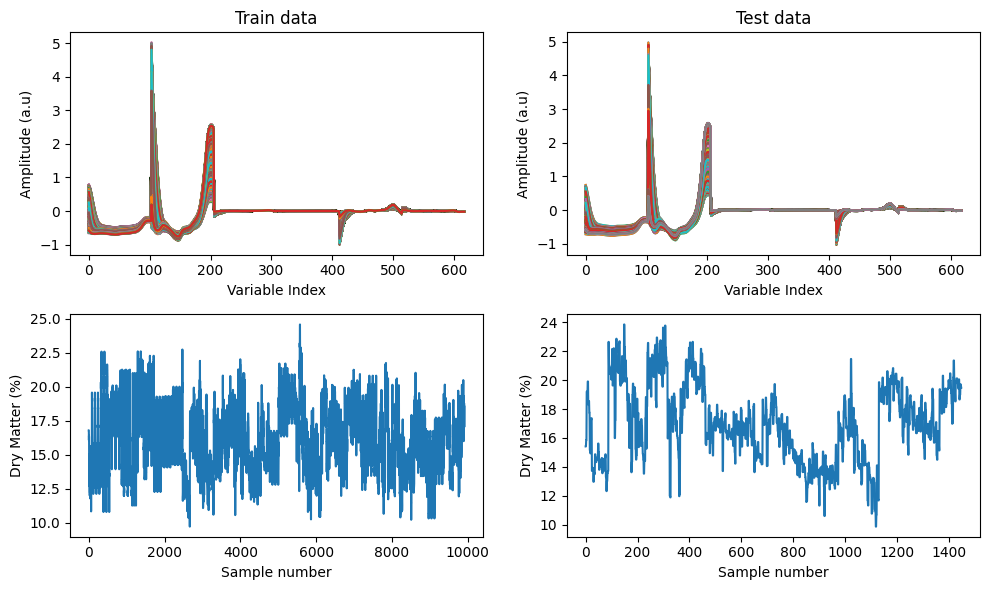

In [5]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title('Train data')
plt.plot(Xcal.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(222)
plt.title('Test data')
plt.plot(Xtest.T)
plt.ylabel('Amplitude (a.u)')
plt.xlabel('Variable Index')
plt.subplot(223)
plt.plot(data['DM_cal'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.subplot(224)
plt.plot(data['DM_test'])
plt.ylabel('Dry Matter (%)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

In [6]:
## Spliting the train set 
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42) 

## The wavelenghts for the XX axis when we plot the spectra
x_scale=data['wave'].astype(np.float32).reshape(-1,1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(Xcal.shape, Ycal.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('val set dims X Y = {}\t{}'.format(x_val.shape, y_val.shape))
print('Test set dims X Y = {}\t{}'.format(Xtest.shape, Ytest.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))

Data set dimensions ----------------------------
Full Train set dims X Y = (9914, 618)	(9914, 1)
Calibration set dims X Y = (7931, 618)	(7931, 1)
val set dims X Y = (1983, 618)	(1983, 1)
Test set dims X Y = (1448, 618)	(1448, 1)
wavelengths number = (103, 1)


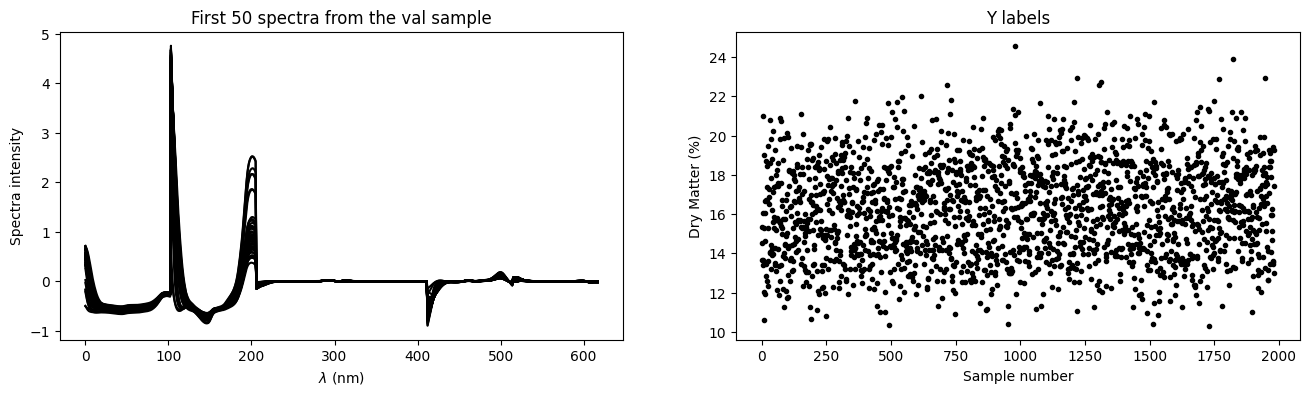

In [7]:
## Visual data sanity checking for the test set
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(x_val[:50,:].T,'k')
plt.title('First 50 spectra from the val sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(1,2,2)
plt.title('Y labels')
plt.plot(y_val,'k.')
plt.xlabel('Sample number')
plt.ylabel('Dry Matter (%)')
plt.show()

In [8]:
# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

model_name ="CuiNet_Mango"
spec_dims = x_cal.shape[1]


# create trainer config
config = TrainerConfig(model_name = model_name)
config.update_config(batch_size=1024,learning_rate=0.01,num_epochs=100,classification=False,max_loss_plot=20)
print(config)

# Convert np.array to Dataloader 
# add dt in loader 

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
cal_loader = data_utils.DataLoader(cal, batch_size=config.batch_size, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = data_utils.DataLoader(val, batch_size=config.batch_size, shuffle=True)

test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))
test_loader = data_utils.DataLoader(test_dt, batch_size=config.batch_size, shuffle=True)


TrainerConfig(batch_size=1024, learning_rate=0.01, num_epochs=100, device=cuda, save_model=True,  classification=False, max_loss_plot=20,save_path=/home/metz/deepchemometrics/Aioly/models/CuiNet_Mango)


CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=614, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_best.pth
Epoch 1/100 | Train Loss: 131.5770 | Val Loss: 31.0434 | Val Mean Metrics: -0.1567
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_best.pth
Epoch 2/100 | Train Loss: 22.3500 | Val Loss: 15.6516 | Val Mean Metrics: 0.0767
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_best.pth
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_best.pth
Epoch 3/100 | Train Loss: 14.7040 | Val Loss: 11.8645 | Val Mean Metrics: 0.1758
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/Cu

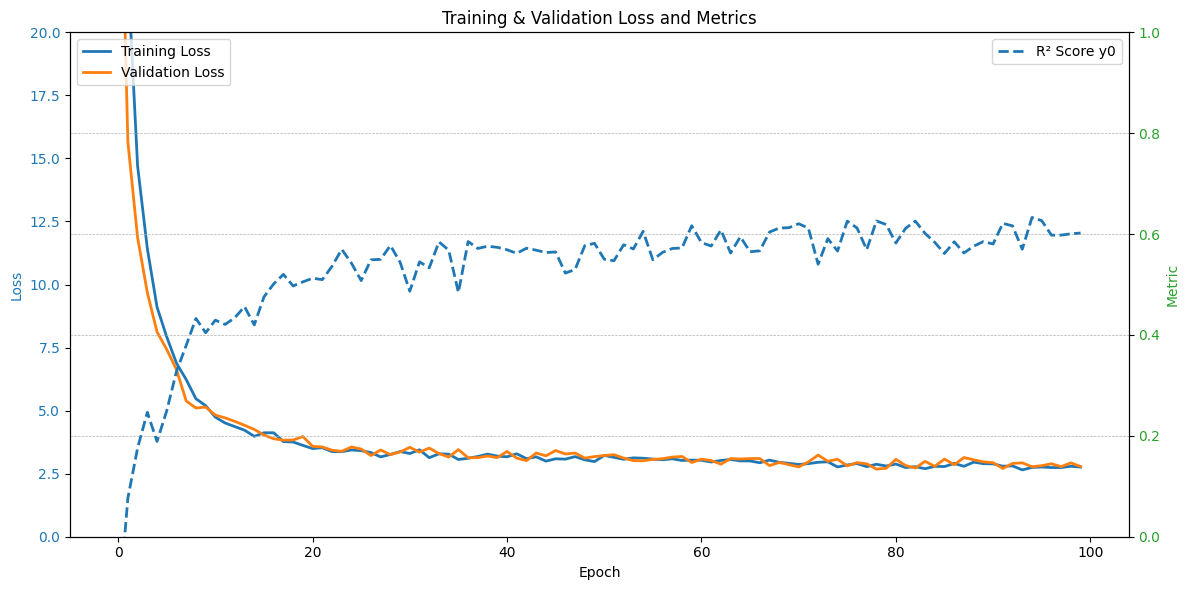

In [9]:
# define model parameters 



model = CuiNet(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
print(model)

trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)

train_losses, val_losses,val_r2_scores, final_path = trainer.train()



In [10]:
print(final_path)

/home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_best.pth


CCC: 0.7816673606593253, R2: 0.5358293652534485, RMSEP: 1.8181147575378418


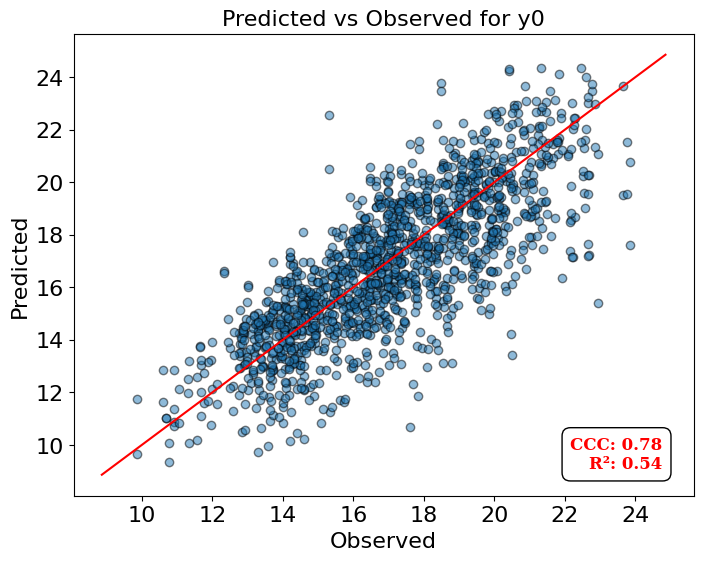

In [11]:

utils.test(model, final_path, test_loader,config)

DeepSpectraCNN(
  (conv1): Conv1d(1, 8, kernel_size=(7,), stride=(3,), padding=(3,))
  (inception2): InceptionModule(
    (branch1): ConvBlock1D(
      (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
      (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch2): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ConvBlock1D(
        (conv1d): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (batchnorm1d): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (branch3): Sequential(
      (0): ConvBlock1D(
        (conv1d): Conv1d(8, 4, kernel_size=(1,), stride=(1,), bias=False)
        (batchnorm1d)

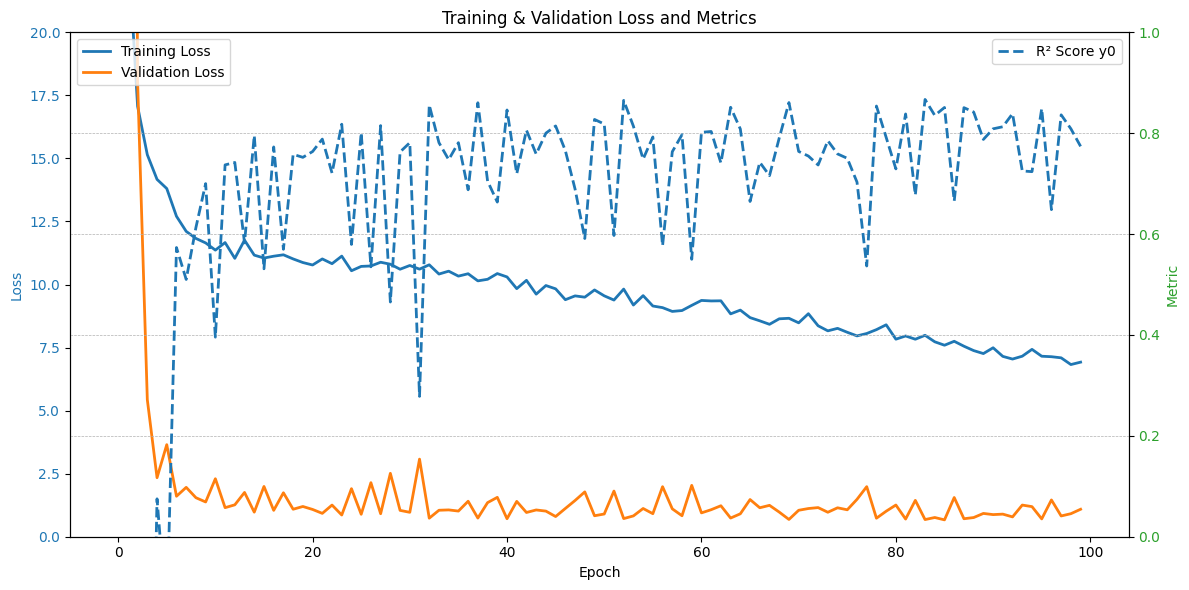

In [12]:
model_name ="DeepSpectra_Mango"
config_deepsp = TrainerConfig(model_name = model_name)
config_deepsp.update_config(batch_size=1024,learning_rate=0.01,num_epochs=100,classification=False,max_loss_plot=20)

model = DeepSpectraCNN(spec_dims, mean = mean,std = std, out_dims=1) 
optimizer = optim.Adam(model.parameters(), lr=config_deepsp.learning_rate, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
print(model)
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config_deepsp)

train_losses, val_losses,val_r2_scores, final_path = trainer.train()


CCC: 0.9217916719393322, R2: 0.8450840711593628, RMSEP: 1.0503414869308472


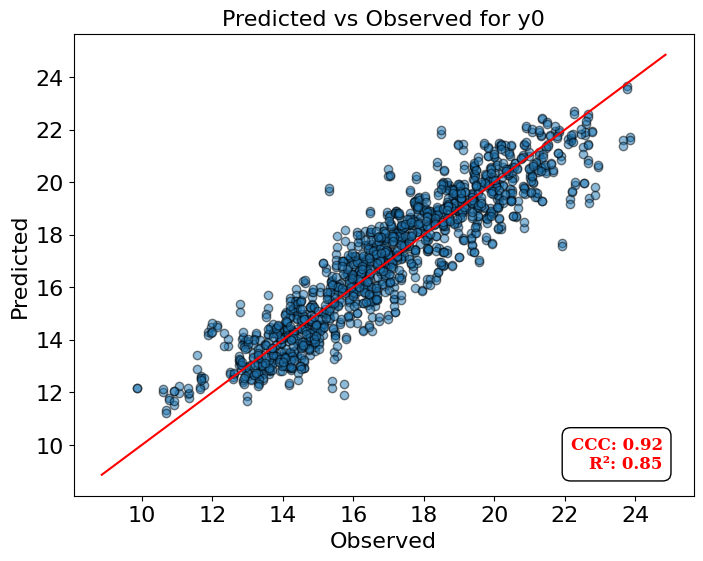

In [13]:
utils.test(model, final_path, test_loader,config)

ResNet1D(
  (conv1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock1D(
      (conv1): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(8, eps=1e-05, 

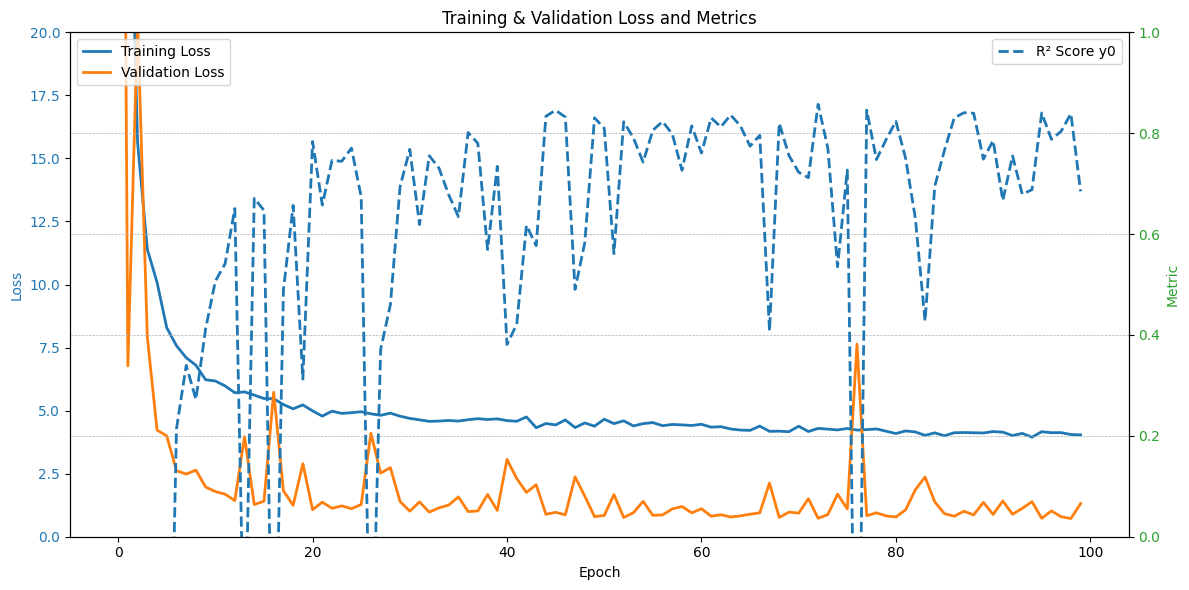

In [14]:
# resnet 18 model test
model_name ="ResNET18_Mango"
config = TrainerConfig(model_name = model_name)
config.update_config(batch_size=1024,learning_rate=0.01,num_epochs=100,classification=False,max_loss_plot=20)

model = ResNet18_1D(mean = mean,std = std, out_dims=1)
optimizer = optim.Adam(model.parameters(), lr=config_deepsp.learning_rate, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
print(model)
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)

train_losses, val_losses,val_r2_scores, final_path = trainer.train()



CCC: 0.8761566292354844, R2: 0.7791870832443237, RMSEP: 1.253991723060608


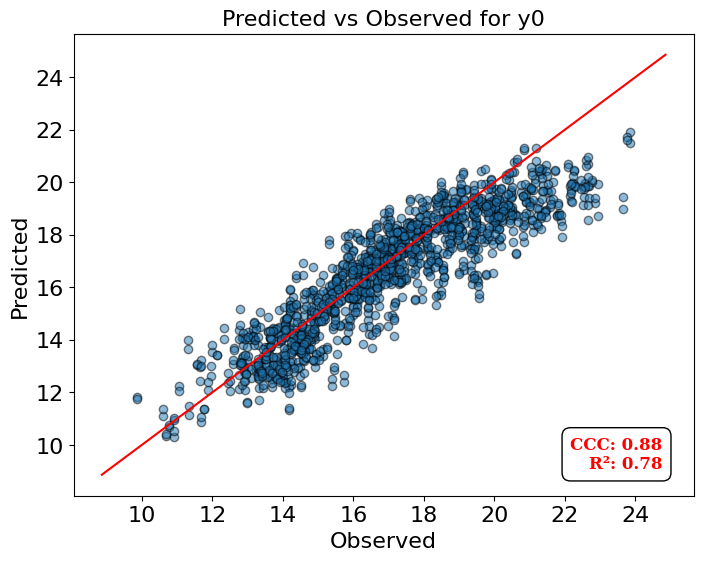

In [15]:
utils.test(model, final_path, test_loader,config)

In [16]:
model_name = "VIT1D"
config = TrainerConfig(model_name = model_name)
config.update_config(batch_size=1024,learning_rate=0.01,num_epochs=20,classification=False,max_loss_plot=20)
print(config)

TrainerConfig(batch_size=1024, learning_rate=0.01, num_epochs=20, device=cuda, save_model=True,  classification=False, max_loss_plot=20,save_path=/home/metz/deepchemometrics/Aioly/models/VIT1D)


ViT_1D(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (n p) -> b n (p c)', p=50)
    (1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=50, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-19): 20 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=128, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_fea

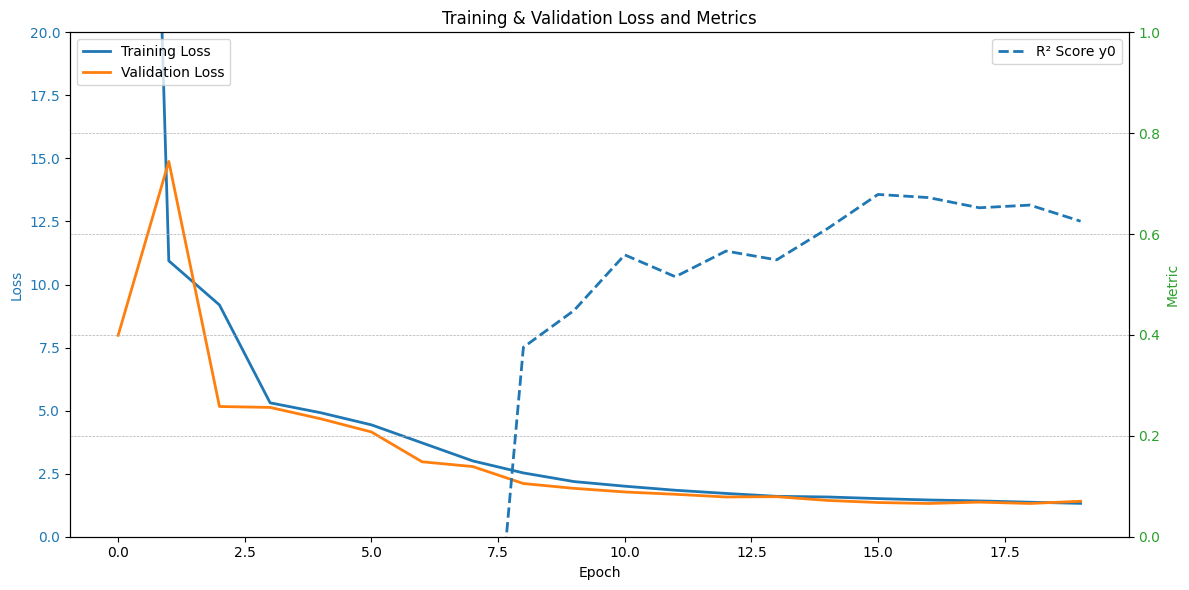

In [17]:

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 50, dim_embed = 128, trans_layers = 20, heads = 8, mlp_dim = 512, out_dims =1, dropout=0.1)
optimizer = optim.Adam(model.parameters(), lr=config_deepsp.learning_rate, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
print(model)
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)

train_losses, val_losses,val_r2_scores, final_path = trainer.train()




CCC: 0.8246357125423807, R2: 0.7261631488800049, RMSEP: 1.396459698677063


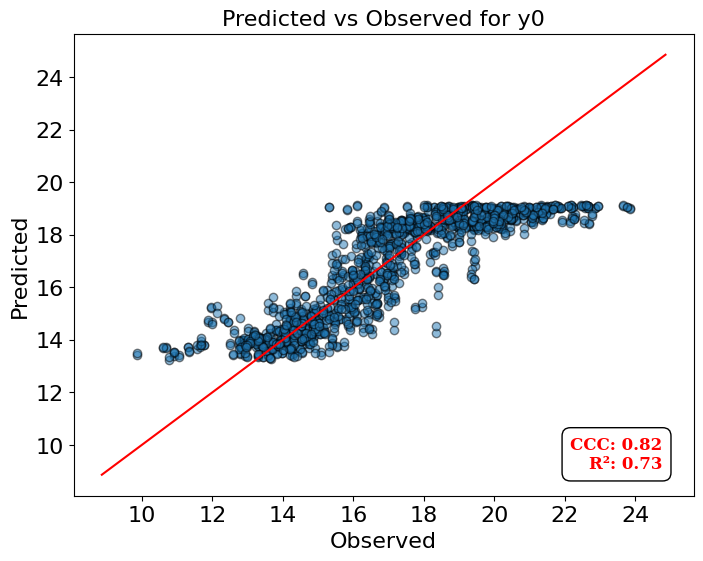

In [18]:
utils.test(model, final_path, test_loader,config)